In [1]:
import time
start = time.time()

In [2]:
import sys
transformer_path = 'D:\FAST\FYP\FYP23-Deep-Document-Clustering\Transformer' # ==== Path for transformer folder
sys.path.insert(0, transformer_path)

In [3]:
import os
data_path = "D:/FAST/FYP/FYP23-Deep-Document-Clustering/data/" # ===== Path for data

In [4]:
import numpy as np
import pandas as pd
import nltk
import os
import warnings
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import f1_score 
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import torch
import random

from utils.Encoder import Encoder
from utils.PositionalEncoding import PositionalEncoding

os.environ['OMP_NUM_THREADS'] = '1'
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_extraction.text")


c:\Users\Ali Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
if torch.cuda.is_available():
    print(f"Available GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Available GPU: NVIDIA GeForce RTX 4090


In [7]:
torch.cuda.memory_allocated()

0

In [8]:
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   torch.manual_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

def Purity_Score(label_seq, pred_labels):
    # Calculate the confusion matrix to compare true labels and cluster assignments
    confusion = confusion_matrix(label_seq, pred_labels)
    # Calculate the purity
    purity = np.sum(np.max(confusion, axis=0)) / np.sum(confusion)
    return purity

def Evaluate(X, true_labels, predicted_labels):
    purity = Purity_Score(true_labels, predicted_labels)
    silhouette = silhouette_score(X, predicted_labels, metric='euclidean')
    ari = ari_score(true_labels, predicted_labels)
    nmi = nmi_score(true_labels, predicted_labels)
    
    print(f"Purity: {purity}")
    print(f"Silhouette Score: {silhouette}")
    print(f"ARI Score: {ari}")
    print(f"NMI Score: {nmi}")

def SaveFeatures(X, file_name):
    pickle_path = open(file_name, 'wb')
    pickle.dump(X, pickle_path)
    pickle_path.close()

def ReadFeatures(file_name):
    pickle_read = open(file_name, 'rb')
    x = pickle.load(pickle_read)
    pickle_read.close()
    return x

In [9]:
os.chdir(data_path)

In [10]:
x = np.loadtxt('acm.txt', dtype=float)
y = np.loadtxt('acm_label.txt', dtype=int)

In [11]:
x = torch.tensor(x, dtype=torch.float32)

In [12]:
x.device

device(type='cpu')

In [13]:
x.size()

torch.Size([3025, 1870])

In [14]:
d_model = 1870
num_heads = 1
drop_prob = 0.1
batch_size = 25
max_sequence_length = 3025
ffn_hidden = 2048
num_layers = 5

In [15]:
pe = PositionalEncoding(d_model=d_model, max_sequence_length=max_sequence_length)
positional_encoding = pe.forward()

In [16]:
positional_encoding.size()

torch.Size([3025, 1870])

In [17]:
x = x + positional_encoding

In [18]:
x = x.reshape(shape=(batch_size, x.size()[0] // batch_size, x.size()[1]))

In [19]:
x.size()

torch.Size([25, 121, 1870])

In [20]:
x = x.cuda()

In [21]:
x.device

device(type='cuda', index=0)

In [22]:
reset_random_seeds(42)
encoder = Encoder(d_model=d_model, ffn_hidden=ffn_hidden, num_heads=num_heads, drop_prob=drop_prob, num_layers=num_layers).cuda()

In [23]:
torch.cuda.memory_allocated()

459858432

In [24]:
for i in encoder.parameters():
    print(i.is_cuda)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [26]:
out = encoder(x)

x.size(): torch.Size([25, 121, 1870])
tensor([[[ 1.0000e+00,  2.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  1.5403e+00,  8.3613e-01,  ...,  1.0000e+00,
           1.0099e-04,  1.0000e+00],
         [ 9.0930e-01,  5.8385e-01,  9.1728e-01,  ...,  1.0000e+00,
           2.0198e-04,  1.0000e+00],
         ...,
         [-9.8195e-01,  1.8913e-01, -5.6828e-01,  ...,  9.9993e-01,
           1.1917e-02,  9.9993e-01],
         [-3.7140e-01,  9.2847e-01, -9.9972e-01,  ...,  9.9993e-01,
           1.2018e-02,  9.9993e-01],
         [ 5.8061e-01,  8.1418e-01, -5.2846e-01,  ...,  9.9993e-01,
           1.2118e-02,  9.9993e-01]],

        [[ 9.9882e-01,  9.5134e-01,  4.1997e-01,  ...,  9.9992e-01,
           1.2219e-02,  9.9993e-01],
         [ 4.9871e-01,  1.3323e-01,  9.8919e-01,  ...,  9.9992e-01,
           1.2320e-02,  9.9992e-01],
         [-4.5990e-01, -8.8797e-01,  6.6522e-01,  ...,  9.9992e-01,
           1.2421e-02,  9.9992e-01],
 

In [27]:
del encoder

In [28]:
def KMeans_Labels(X, n, rstate_limit, true_labels):
    # Specify the number of clusters (you can choose an appropriate value)
    num_clusters = n
    
    # find centoids which give maximum purity
    purity_collection = {}
    for i in range(rstate_limit):
        clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=i, init='k-means++').fit(X).labels_
        purity_collection[i] = Purity_Score(true_labels, clusters)
    
    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    plot_graph(purity_collection.keys(), purity_collection.values())
    
    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the TF-IDF data
    kmeans.fit(X)
    # Get the cluster assignments for each document
    cluster_assignments = kmeans.labels_
    
    return cluster_assignments

def plot_graph(x, y):
    plt.scatter(x, y, marker = "o")
    plt.title("Purity x Random State")
    plt.ylabel("Purity")
    plt.xlabel("Random State")
    plt.show()

def calculate_purity(random_state, X, true_labels):
    clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=random_state, init='k-means++').fit(X).labels_
    purity = Purity_Score(true_labels, clusters)
    return random_state, purity

def KMeans_Labels_Parallel(X, n, rstate_limit, true_labels):
    # Specify the number of clusters (you can choose an appropriate value)
    global num_clusters
    num_clusters = n
    
    # Use ThreadPoolExecutor to parallelize purity calculations
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(calculate_purity, i, X, true_labels): i for i in range(rstate_limit)}

    purity_collection = {future.result()[0]: future.result()[1] for future in futures}

    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    plot_graph(purity_collection.keys(), purity_collection.values())
    
    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the data
    kmeans.fit(X)
    # Get the cluster assignments for each data point
    cluster_assignments = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    
    return cluster_assignments, cluster_centers


In [29]:
reshaped_out = out.reshape(out.size()[0] * out.size()[1], out.size()[2])

In [30]:
reshaped_out.size()

torch.Size([3025, 1870])

Maximum purity of 0.980495867768595 found on random state 10


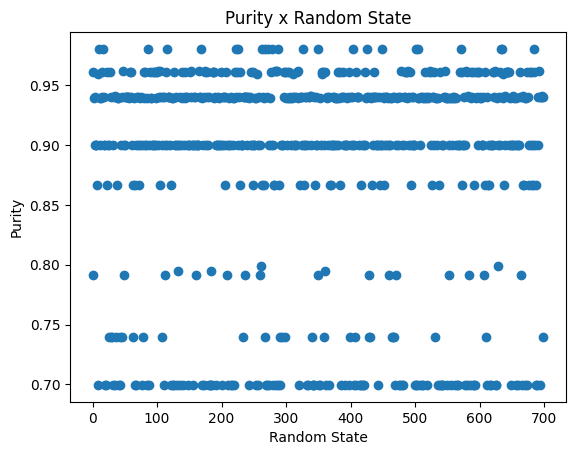

In [31]:
enhanced_x = reshaped_out.cpu().detach().numpy()
true_labels = y
pred_lables, centoids = KMeans_Labels_Parallel(enhanced_x, 3, 700, true_labels)

In [32]:
Evaluate(enhanced_x, true_labels, pred_lables)

Purity: 0.980495867768595
Silhouette Score: 0.09813302755355835
ARI Score: 0.9434767144835919
NMI Score: 0.9198441071486002


In [33]:
def visualize_clusters(X, cluster_assignments, cluster_centers, num_dimensions=2):
    # Apply PCA to reduce the dimensions for visualization
    pca = PCA(n_components=num_dimensions)
    X_pca = pca.fit_transform(X)

    # Combine data and cluster assignments into a DataFrame
    data_with_clusters = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, num_dimensions+1)])
    data_with_clusters['Cluster'] = cluster_assignments

    # Scatter plot with different colors for each cluster
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=data_with_clusters, palette='viridis', s=80, alpha=0.8)
    
    # Plot cluster centers if available
    centers = pca.transform(cluster_centers)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
    
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


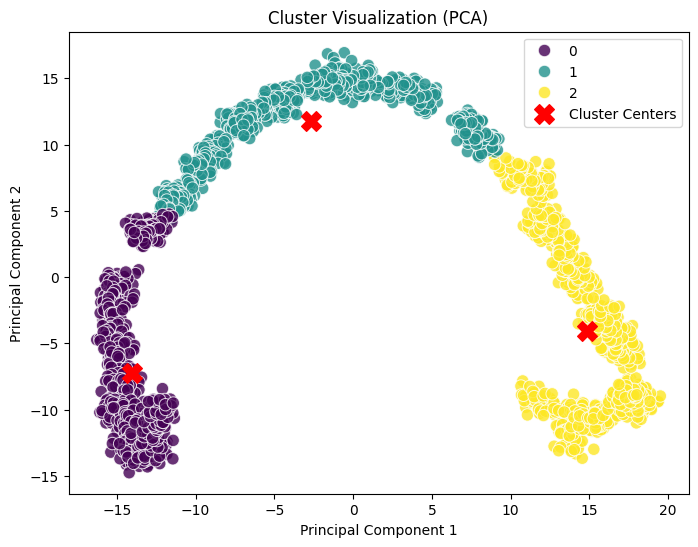

In [34]:
visualize_clusters(enhanced_x, pred_lables, cluster_centers=centoids, num_dimensions=2)

In [35]:
i=0
while i<len(true_labels):
    print(f"From {i} - {i+300}")
    print(f"True Label Batch {i}-{i+300}: {true_labels[i:i+300]}")
    print(f"Pred Label Batch {i}-{i+300} : {pred_lables[i:i+300]}")
    i+=300

From 0 - 300
True Label Batch 0-300: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Pred Label Batch 0-300 : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2

In [36]:
end = time.time()
time_taken = end - start

In [37]:
print(f"Time taken: {time_taken:.2f}s")

Time taken: 27.17s
